# Object Detection on Torchvision Dataset

## Load Dataset

In [1]:
img_size = 256
patch_size = 16
batch_size = 8

In [37]:
import os
import xml.etree.ElementTree as ET
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import Dataset
from PIL import Image
import torch

class OxfordIIITPetHeadROI(Dataset):
    def __init__(self, root, split="trainval", download=True, transform=None, img_size=(256, 256)):
        # Initialize the base torchvision dataset
        self.dataset = OxfordIIITPet(root=root, split=split, download=download, transform=transform)
        self.root = root + "\\oxford-iiit-pet"
        self.img_size = img_size # Store the target image size
        self.split = split

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if self.split == "trainval":
            try:
                # We need to get the original image to determine its size before transformation
                # to correctly scale the bounding box.
                # The transform is applied later by the DataLoader.
                original_image_path = self.dataset._images[idx]
                original_image = Image.open(original_image_path).convert("RGB")
                original_width, original_height = original_image.size

                image, label = self.dataset[idx] # This applies the transform including resize
                
                # Get the image filename from the dataset's metadata
                filename = os.path.basename(original_image_path)
                
                # Build the full path to the XML annotation file
                xml_path = os.path.join(self.root, "annotations", "xmls", filename[:-4] + ".xml")

                # Parse the XML to get the head ROI bounding box
                tree = ET.parse(xml_path)
                root = tree.getroot()
                
                bndbox = root.find('object').find('bndbox')
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)

                # Calculate scaling factors
                scale_x = self.img_size[0] / original_width
                scale_y = self.img_size[1] / original_height

                # Apply scaling to bounding box coordinates
                xmin = int(xmin * scale_x)
                ymin = int(ymin * scale_y)
                xmax = int(xmax * scale_x)
                ymax = int(ymax * scale_y)
                
                cx = ((xmin + xmax) / 2.0) / self.img_size[0]
                cy = ((ymin + ymax) / 2.0) / self.img_size[1]
                w = (xmax - xmin) / self.img_size[0]
                h = (ymax - ymin) / self.img_size[1]
                
                bbox = [cx, cy, w, h]

                objects = [{'category': torch.tensor([label], dtype=torch.int64), 'bbox': torch.tensor([bbox], dtype=torch.float32)}]
                
                return image, objects
            except FileNotFoundError:
                # print(f"Warning: Skipping example {idx} due to FileNotFoundError for image or XML file at index {idx}.")
                return None, None # Return None for both image and objects
            except Exception as e:
                # print(f"Warning: Skipping example {idx} due to an unexpected error: {e} at index {idx}.")
                return None, None
        else:
            image, label = self.dataset[idx]
            return image, label 

def collate_fn(batch):
    images = []
    targets = []
    # Filter out None values from the batch
    batch = [item for item in batch if item[0] is not None and item[1] is not None]
    
    if not batch: # If all items were None, return empty tensors or handle as appropriate
        return torch.tensor([]), [] # Return empty tensors if the batch is empty
        
    for img, obj in batch:
        images.append(img)
        targets.extend(obj)
    
    images = torch.stack(images, 0)
    return images, targets

In [38]:
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

trainset = OxfordIIITPetHeadROI(root='./data', split="trainval", download=True, transform=transform, img_size=(img_size, img_size))
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

classes = trainset.dataset.classes

In [35]:
for batch in train_loader:
    images, objects = batch
    print(type(images), type(objects))

    
    print(f'Batch size: {len(objects)}')
    print(f'Image tensor shape: {images.shape}')  # B C, W, H
    print(f'Object: {objects[0]}')
    break

<class 'torch.Tensor'> <class 'list'>
Batch size: 8
Image tensor shape: torch.Size([8, 3, 256, 256])
Object: {'category': tensor([13]), 'bbox': tensor([[0.4980, 0.3281, 0.3164, 0.4453]])}


{'category': tensor([34]), 'bbox': tensor([[0.3027, 0.3125, 0.3242, 0.2109]])}
tensor([34]) tensor([[0.3027, 0.3125, 0.3242, 0.2109]])
Label: Staffordshire Bull Terrier


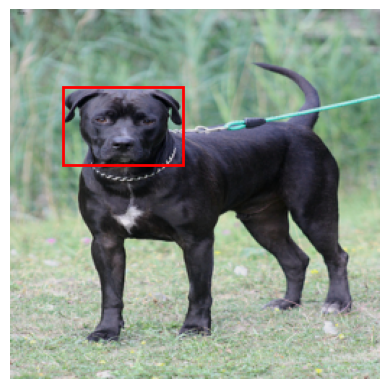

In [36]:
# Show one training image and its label
dataiter = iter(train_loader)
images, objects = next(dataiter)

def imshow(img, obj):
    print(obj)
    label, bbox = obj['category'], obj['bbox']
    print(label, bbox)
    print("Label:", classes[label])
    # Un-normalize the image
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img * std + mean
    npimg = img.numpy()
    
    # Create a figure and axes
    fig, ax = plt.subplots(1)
    
    # Display the image
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    
    # Get bounding box coordinates
    cx, cy, w_norm, h_norm = [b for b in bbox[0].tolist()]

    # Convert normalized coordinates back to pixel coordinates for plotting
    # img_size is defined globally in the notebook
    image_width, image_height = img_size, img_size 
    
    xmin = (cx - w_norm / 2) * image_width
    ymin = (cy - h_norm / 2) * image_height
    xmax = (cx + w_norm / 2) * image_width
    ymax = (cy + h_norm / 2) * image_height

    width = xmax - xmin
    height = ymax - ymin
    
    # Create a Rectangle patch
    rect = plt.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
    
    
    # Add the patch to the Axes
    ax.add_patch(rect)
    
    plt.axis('off')
    plt.show()

imshow(images[0], objects[0])

## Create Model

In [6]:
# model parameters
img_size = img_size         # resized images
in_channels = 3       # RGB
n_classes = len(classes) # no "no object" class necessary based on loss function (which uses eos for that)

n_enc_layers = 6
n_dec_layers = 6
n_queries = 2       # max number of objects in an image

patch_size = patch_size        
emb_dim = 256         # Embedding dimension (can be tuned)
n_heads = 8           # Number of attention heads
dropout = 0.1         # Dropout rate

In [7]:
from detection_model import VisionDetectionModel

model = VisionDetectionModel(img_size, patch_size, in_channels, emb_dim, n_heads, n_enc_layers, n_dec_layers, n_queries, n_classes, dropout)
print(model)

# Show total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters: {total_params}')

VisionDetectionModel(
  (encoder): VisionEncoder(
    (patch_embed): PatchEmbedding(
      (proj): Conv2d(3, 256, kernel_size=(16, 16), stride=(16, 16))
    )
    (positional_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.1, inplace=False)
    (encoder): ModuleList(
      (0-5): 6 x TransformerEncoder(
        (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (mha): MultiHeadAttention(
          (W_o): Linear(in_features=256, out_features=256, bias=False)
          (heads): ModuleList(
            (0-7): 8 x AttentionHead(
              (query): Linear(in_features=256, out_features=32, bias=False)
              (key): Linear(in_features=256, out_features=32, bias=False)
              (value): Linear(in_features=256, out_features=32, bias=False)
            )
          )
        )
        (dropout1): Dropout(p=0.1, inplace=False)
        (ln2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_featu

## Training

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [9]:
import loss
import matcher

weight_dict = {
    'loss_ce': 1,      # Classification loss
    'loss_bbox': 5,    # Bounding box L1 loss
    'loss_giou': 2     # Bounding box GIoU loss
}

HMatcher = matcher.HungarianMatcher()

criterion = loss.SetCriterion(num_classes=n_classes, matcher=HMatcher, weight_dict=weight_dict, eos_coef=0.1, losses=['labels', 'boxes'])

In [ ]:
from tqdm import tqdm
model = model.to(device)
criterion = criterion.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

num_epochs = 100
batch_size = batch_size

# train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)




for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    loop = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
    for images, objects in loop:
        images = images.to(device)
        targets= [{k: v.to(device) for k, v in t.items()} for t in objects]

        optimizer.zero_grad()

        outputs = model(images)

        loss_dict = criterion(outputs,  targets)
        loss = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys())

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * len(images)
        loop.set_postfix(loss=loss.item())
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss:.4f}')

Epoch 1/100 | Loss: 7.5855


Epoch 2/100 | Loss: 7.3340


Epoch 3/100 | Loss: 7.2673


Epoch 4/100 | Loss: 7.1529


Epoch 5/100 | Loss: 7.0371


Epoch 6/100 | Loss: 6.9074


Epoch 7/100 | Loss: 6.7884


Epoch 8/100 | Loss: 6.7189


Epoch 9/100 | Loss: 6.6562


Epoch 10/100 | Loss: 6.6001


Epoch 11/100 | Loss: 6.5589


Epoch 12/100 | Loss: 6.5132


Epoch 13/100 | Loss: 6.4978


Epoch 14/100 | Loss: 6.4458


Epoch 15/100 | Loss: 6.4132


Epoch 16/100 | Loss: 6.3493


Epoch 17/100 | Loss: 6.3435


Epoch 18/100 | Loss: 6.2462


Epoch 19/100 | Loss: 6.1980


Epoch 20/100 | Loss: 6.1409


Epoch 21/100 | Loss: 6.0961


Epoch 22/100 | Loss: 6.0679


Epoch 23/100 | Loss: 6.0218


Epoch 24/100 | Loss: 6.0280


Epoch 25/100 | Loss: 5.9140


Epoch 26/100 | Loss: 5.8852


Epoch 27/100 | Loss: 5.8902


Epoch 28/100 | Loss: 5.8454


Epoch 29/100 | Loss: 5.8025


Epoch 30/100 | Loss: 5.8022


Epoch 31/100 | Loss: 5.7205


Epoch 32/100 | Loss: 5.7725


Epoch 33/100 | Loss: 5.7171


Epoch 34/100 | Loss: 5.6755


Epoch 35/100 | Loss: 5.6135


Epoch 36/100 | Loss: 5.5554


Epoch 37/100 | Loss: 5.4949


Epoch 38/100 | Loss: 5.4772


Epoch 39/100 | Loss: 5.4334


Epoch 40/100 | Loss: 5.4601


Epoch 41/100 | Loss: 5.4145


Epoch 42/100 | Loss: 5.2750


Epoch 43/100 | Loss: 5.1959


Epoch 44/100 | Loss: 5.1410


Epoch 45/100 | Loss: 5.0800


Epoch 46/100 | Loss: 5.1019


Epoch 47/100 | Loss: 5.1657


Epoch 48/100 | Loss: 5.0895


Epoch 49/100 | Loss: 4.8791


Epoch 50/100 | Loss: 4.9259


Epoch 51/100 | Loss: 4.8606


Epoch 52/100 | Loss: 4.8248


Epoch 53/100 | Loss: 4.8639


Epoch 54/100 | Loss: 4.7145


Epoch 55/100 | Loss: 4.8175


Epoch 56/100 | Loss: 4.6709


Epoch 57/100 | Loss: 4.6031


Epoch 58/100 | Loss: 4.5022


Epoch 59/100 | Loss: 4.4777


Epoch 60/100 | Loss: 4.3584


Epoch 61/100 | Loss: 4.3670


Epoch 62/100 | Loss: 4.4252


Epoch 63/100 | Loss: 4.3809


Epoch 64/100 | Loss: 4.5942


Epoch 65/100 | Loss: 4.5064


Epoch 66/100 | Loss: 4.4147


Epoch 67/100 | Loss: 4.2440


Epoch 68/100 | Loss: 4.1477


Epoch 69/100 | Loss: 4.1715


Epoch 70/100 | Loss: 4.2424


Epoch 71/100 | Loss: 4.1434


Epoch 72/100 | Loss: 3.9201


Epoch 73/100 | Loss: 4.0321


Epoch 74/100 | Loss: 4.3124


Epoch 75/100 | Loss: 4.0753


Epoch 76/100 | Loss: 3.8557


Epoch 77/100 | Loss: 3.8701


Epoch 78/100 | Loss: 3.9118


Epoch 79/100 | Loss: 3.6534


Epoch 80/100 | Loss: 3.7649


Epoch 81/100 | Loss: 3.6049


Epoch 82/100 | Loss: 3.6349


Epoch 83/100 | Loss: 3.5272


Epoch 84/100 | Loss: 3.4487


Epoch 85/100 | Loss: 3.4130


Epoch 86/100 | Loss: 3.3062


Epoch 87/100 | Loss: 3.4693


Epoch 88/100 | Loss: 3.3473


Epoch 89/100 | Loss: 3.6227


Epoch 90/100 | Loss: 3.5527


Epoch 91/100 | Loss: 3.2752


Epoch 92/100 | Loss: 3.3344


Epoch 93/100 | Loss: 3.2953


Epoch 94/100 | Loss: 3.2372


Epoch 95/100 | Loss: 3.0652


Epoch 96/100 | Loss: 3.1216


Epoch 97/100 | Loss: 3.0392


Epoch 98/100 | Loss: 3.4147


Epoch 99/100 | Loss: 3.1365


Epoch 100/100 | Loss: 3.0894


## Inference

In [41]:
from tqdm import tqdm

import torchvision.ops

# Create test dataloader
testset = OxfordIIITPetHeadROI(root='./data', split="test", download=True, transform=transform, img_size=(img_size, img_size))
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [42]:
import torch.nn as nn
import torch.nn.functional as F
import util

class PostProcess(nn.Module):
    """ This module converts the model's output into the format expected by the coco api"""
    @torch.no_grad()
    def forward(self, outputs, target_sizes):
        """ Perform the computation
        Parameters:
            outputs: raw outputs of the model
            target_sizes: tensor of dimension [batch_size x 2] containing the size of each images of the batch
                          For evaluation, this must be the original image size (before any data augmentation)
                          For visualization, this should be the image size after data augment, but before padding
        """
        out_logits, out_bbox = outputs['pred_logits'], outputs['pred_boxes']

        assert len(out_logits) == len(target_sizes)
        assert target_sizes.shape[1] == 2

        prob = F.softmax(out_logits, -1)
        scores, labels = prob[..., :-1].max(-1)

        # convert to [x0, y0, x1, y1] format
        boxes = util.box_cxcywh_to_xyxy(out_bbox)
        # and from relative [0, 1] to absolute [0, height] coordinates
        img_h, img_w = target_sizes.unbind(1)
        scale_fct = torch.stack([img_w, img_h, img_w, img_h], dim=1)
        boxes = boxes * scale_fct[:, None, :]

        results = [{'scores': s, 'labels': l, 'boxes': b} for s, l, b in zip(scores, labels, boxes)]

        return results
    
postprocessor = PostProcess()

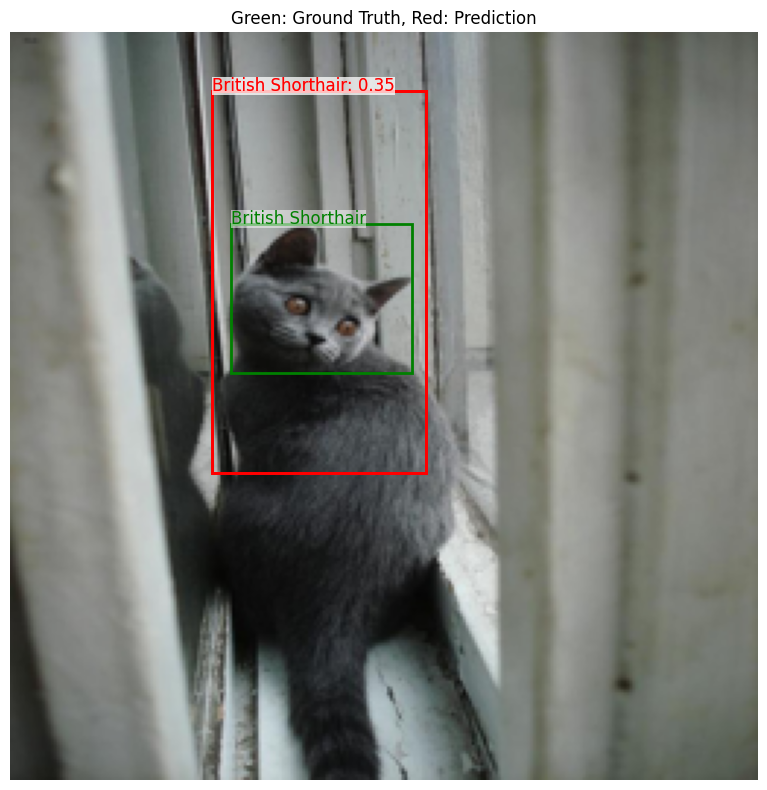

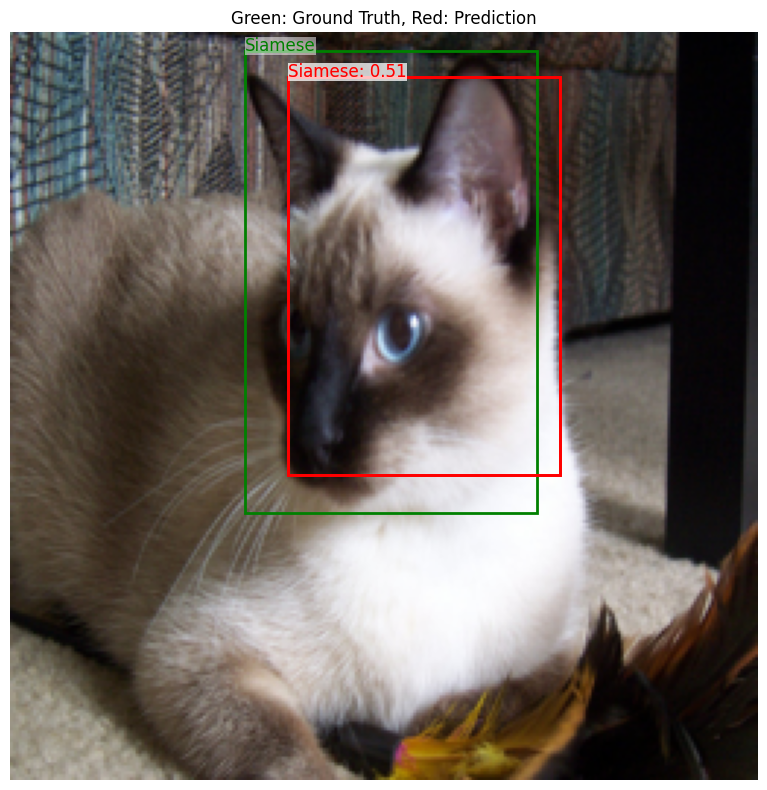

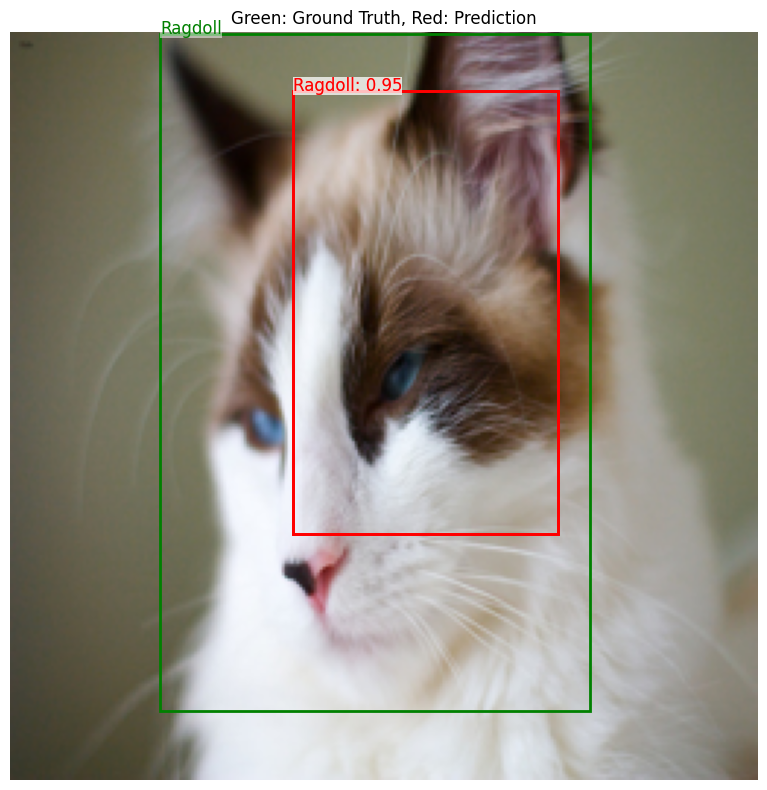

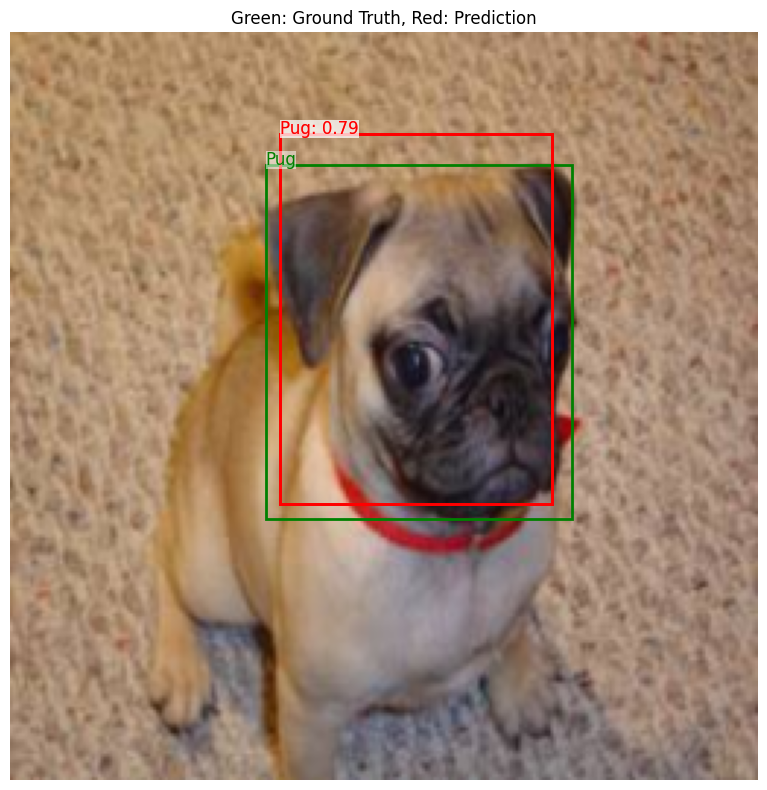

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

images, targets = next(iter(train_loader))
# images, targets = one_batch_images, one_batch_objects 
images = images.to(device)

model.eval()
with torch.no_grad():
    outputs = model(images)


batch_size = images.shape[0]
target_sizes = torch.tensor([[img_size, img_size]] * batch_size, device=device)
results = postprocessor(outputs, target_sizes)

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])


num_images_to_show = 4
for i in range(min(num_images_to_show, len(images))):
    fig, ax = plt.subplots(1, figsize=(8, 8))
    
    # Prepare image for display (denormalize and reorder dimensions)
    img = images[i].cpu().numpy().transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1)
    ax.imshow(img)

    # Plot ground truth boxes (in green)
    gt_labels = targets[i]['category']
    gt_boxes = targets[i]['bbox']
    if len(gt_boxes) > 0:
        gt_boxes_xyxy = util.box_cxcywh_to_xyxy(gt_boxes) * img_size
        for label, box in zip(gt_labels, gt_boxes_xyxy):
            x_min, y_min, x_max, y_max = box
            rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='g', facecolor='none')
            ax.add_patch(rect)
            ax.text(x_min, y_min, classes[label], color='g', fontsize=12, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=0))

    # Plot predicted boxes that passed the confidence threshold (in red)
    result_i = results[i]
    
    # Filter by confidence threshold
    keep = result_i['scores'] > 0.0
    pred_boxes_xyxy = result_i['boxes'][keep].cpu()
    pred_labels_i = result_i['labels'][keep].cpu()
    pred_scores_i = result_i['scores'][keep].cpu()
      
    for label, score, box in zip(pred_labels_i, pred_scores_i, pred_boxes_xyxy):
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x_min, y_min, f'{classes[label]}: {score:.2f}', color='r', fontsize=12, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=0))

    ax.set_title("Green: Ground Truth, Red: Prediction")
    ax.axis('off')
    plt.tight_layout()
    plt.show()